# ML for Time Series in Python and Prophet
# Practical approach


In [11]:
import numpy as np                               # работа с векторами и матрицами
import pandas as pd                              # таблицы и операции над данными
import matplotlib.pyplot as plt                  # графики
import seaborn as sns                            # еще графики

from dateutil.relativedelta import relativedelta # для комфортной работы с датами
from scipy.optimize import minimize              # позволяет минимизировать функции

import statsmodels.formula.api as smf            # всякая статистика и эконометрика
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # немножко функций для удобства
from tqdm import tqdm_notebook

import warnings                                  # скрыть ошибки кода
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
ads = pd.read_csv(r'D:\GITHUB\DA_NEW\Datasets\ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv(r'D:\GITHUB\DA_NEW\Datasets\currency.csv', index_col=['Time'], parse_dates=['Time'])

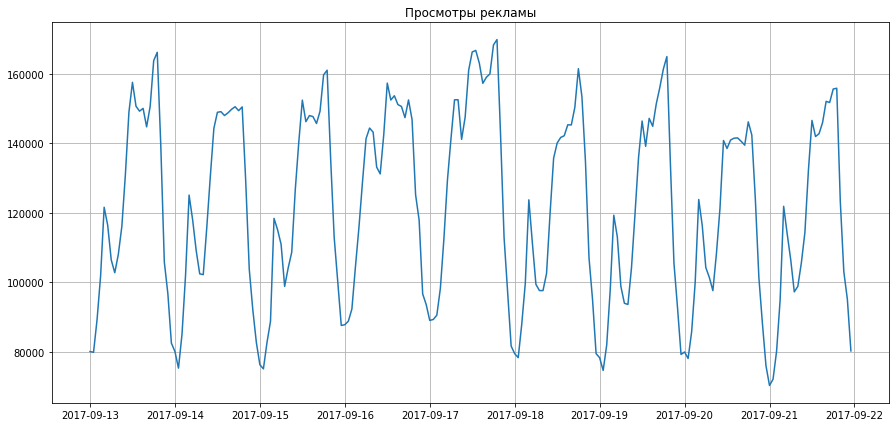

In [6]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Просмотры рекламы')
plt.grid(True)
plt.show()

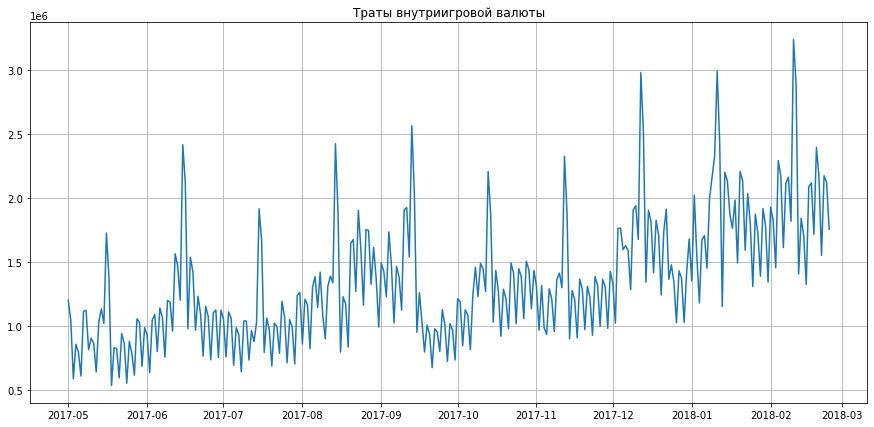

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('Траты внутриигровой валюты')
plt.grid(True)
plt.show()

#  Machine Learning для временных рядов

### Временные ряды без правил или прогнозируем, чем можем

Часто на практике приходится строить модели, руководствуясь одним основополагающим принципом – [быстро, качественно, недорого](http://lurkmore.to/%D0%91%D1%8B%D1%81%D1%82%D1%80%D0%BE,_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE,_%D0%BD%D0%B5%D0%B4%D0%BE%D1%80%D0%BE%D0%B3%D0%BE). Поэтому часть моделей могут банально не подойти для "продакшн-решений", так как либо требуют слишком больших затрат по подготовке данных, либо сложно настраиваются, либо требуют частого переобучения на новых данных, поэтому зачастую гораздо проще бывает выделить несколько признаков из имеющегося временного ряда и построить по ним обычную линейную регрессию или навесить решаюший лес. Дешево и сердито.


Возможно, этот подход не является значительно подкрепленным теорией, нарушает различные предпосылки, например, условия Гаусса-Маркова, особенно пункт про некоррелированность ошибок, однако на практике нередко выручает и достаточно активно используется в соревнованиях по машинному обучению.

### Извлечение признаков (Feature exctraction)

Итак, для модели нужны признаки, а у нас есть только одномерный временной ряд, что можно придумать?

* Конечно же, лаги временного ряда
* Статистики по окнам:
    - Минимальное/максимальное значение ряда в окне
    - Среднеё/медианное значение по окну
    - Дисперсия по окну
    - и т.д.
* Признаки из самой даты и времени:
    - Минута часа, час дня, день недели, месяц года и т.д.
    - Является ли день праздником/выходным/специфическим днём
* Кодирование средним
* Прогнозы других моделей (но тут в скорости можно потерять)

Пройдемся по некоторым из способов и посмотрим, что мы можем вытащить из нашего временного ряда с рекламой

- Лаги временного ряда

Сдвигая ряд на $n$ шагов мы получаем столбец-признак, в котором текущему значению ряда в момент $t$ будет соответствовать его значение в момент времени $t-n$. Таким образом, если сделать отступ в 1 шаг, то модель, обученная на таком признаке, будет способна давать предсказание на 1 шаг вперед, зная текущее состояние ряда. Увеличивая сдвиг, например, до 6 лага позволит модели делать предсказания на 6 шагов вперёд, однако опираться она будет на данные, которые видела 6 временных периодов назад и если за это время что-то кардинально поменялось, модель сразу не уловит изменений и выдаст прогноз с большой ошибкой. Поэтому при выборе начального лага приходиться балансировать между желанием получить предсказания на бОльшее число периодов вперёд и приемлимым качеством предсказания

In [8]:
# Создадим копию исходного датафрейма реклама, чтобы можно было выполнять различные преобразования
data = pd.DataFrame(ads.Ads.copy())
data.columns = ["y"]

In [9]:
# Добавляем лаги целевой переменной
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [79]:
# посмотрим, как теперь выглядит датасет
data.tail(7)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Time,,,,,,,,,,,,,,,,,,,,
2017-09-21 17:00:00,151790,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0,139515.0
2017-09-21 18:00:00,155665,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0


строим регрессионную модель  

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# для рассчета ошибки на кросс-валидации будем бить ряд на 5 фолдов
tscv = TimeSeriesSplit(n_splits=5)

In [19]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(X)*(1-test_size))
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [20]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# разбиваем датасет на тренировочную и тестовую часть, отложим 30% данных
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [21]:
# учим регрессию
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
    Строит график прогнозных и фактических значений, а также доверительных интервалов прогноза и аномалий
    
    """
    
    # получаем предсказания по модели
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
    Отрисовывает отсортированные по абсолютному значению коэффициенты модели
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

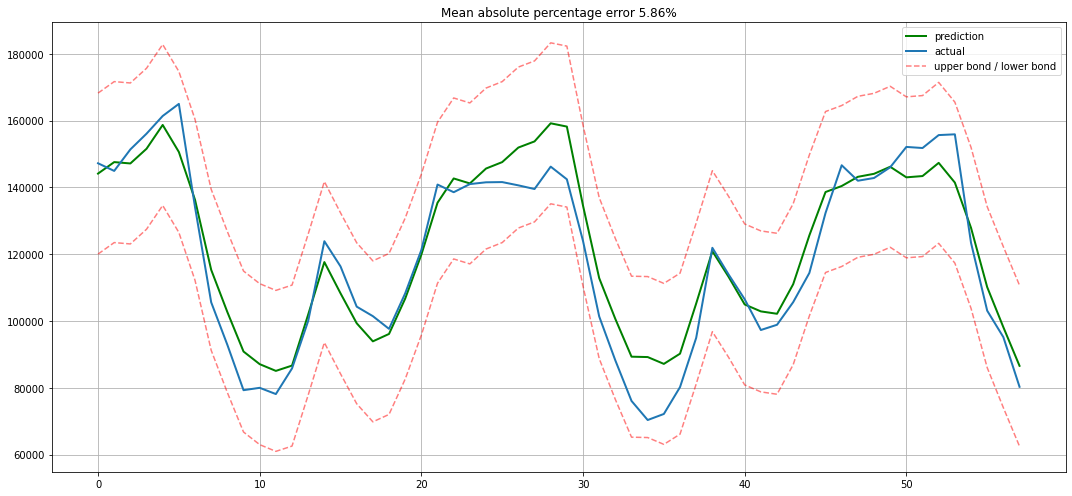

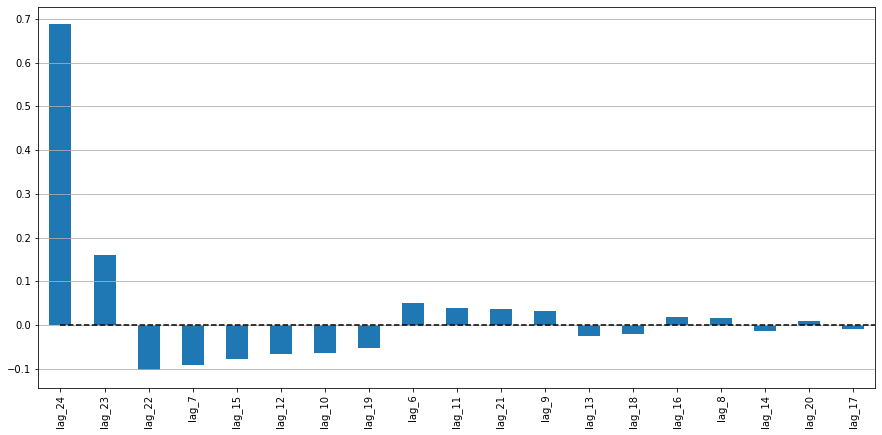

In [27]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Что ж, всего лишь простыми лагами удалось построить модель, которая не сильно уступает по качеству SARIMA модели. Продолжим придумывать признаки!

Добавим в датасет час, день недели и выходной в качестве категориальных переменных. Для этого переводим имеющийся в датафрейме индекс в формат `datetime`, и извлекаем из него `hour` и `weekday`.

In [29]:
data.index = data.index.to_pydatetime()
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,...,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,19,3,0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,...,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,20,3,0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,...,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,21,3,0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,...,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,22,3,0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,...,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,23,3,0


Можно визуализировать получившиеся признаки

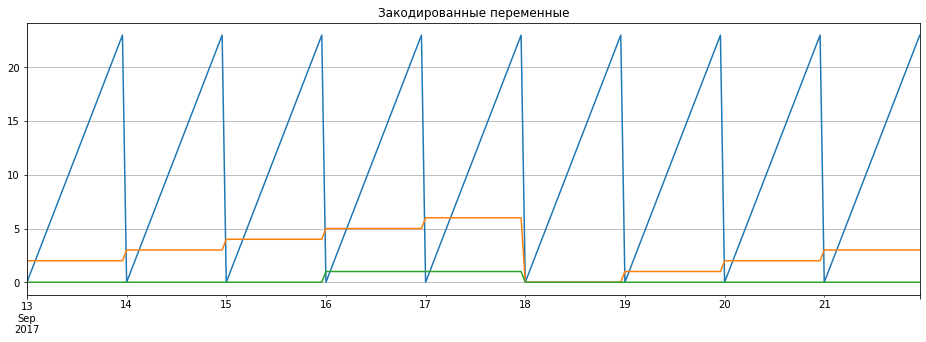

In [30]:
plt.figure(figsize=(16, 5))
plt.title("Закодированные переменные")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

Так как теперь у нас данные в разном масштабе - десятки тысяч в лагах и единицы в категориях, имеет смысл привести всё к одному масштабу, чтобы можно было по-прежнему исследовать коэффициенты модели. Для этого воспользуемся `StandardScaler`

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

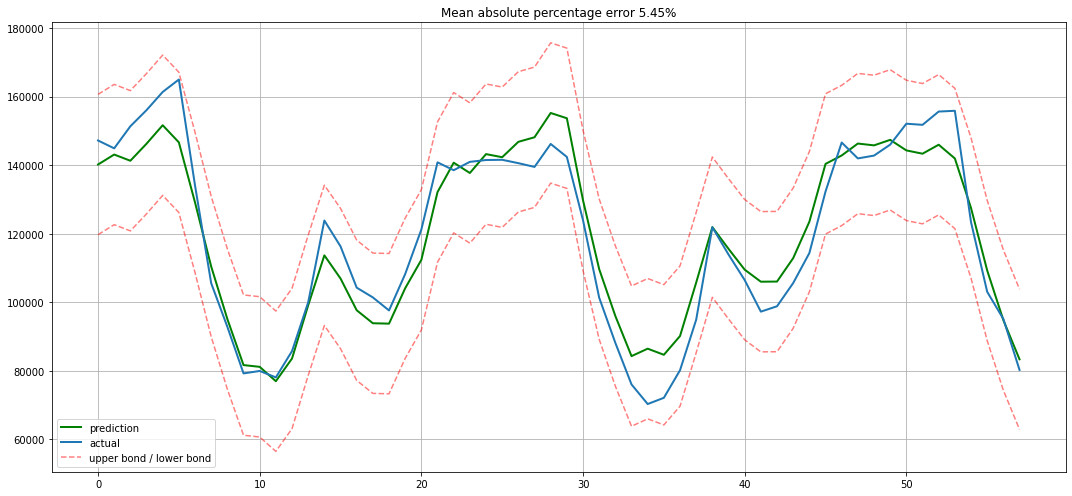

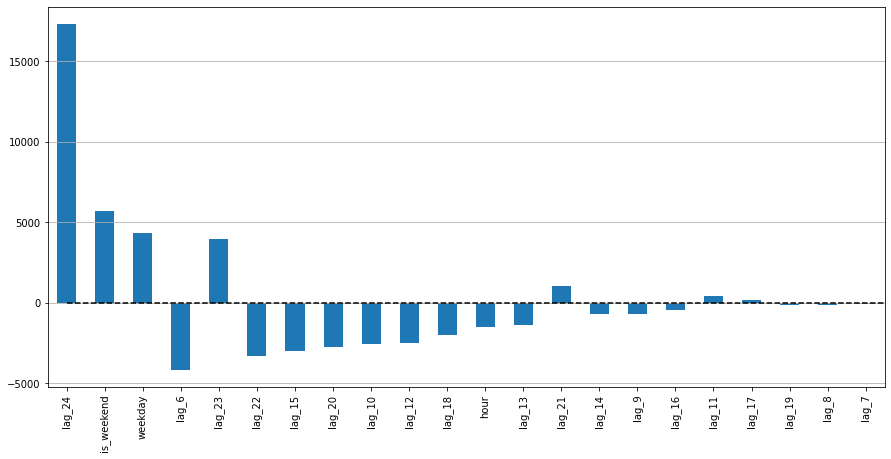

In [33]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# разбиваем датасет на тренировочную и тестовую часть, отложим 30% данных
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

Ошибка на тесте еще немного уменьшилась, и по коэффициентам видно, что день недели и выходной - довольно неплохие признаки

**Кодирование средним**

Иногда в качестве признака добавлять среднее значение целевой переменной. В нашем случае каждый день недели или час дня можно закодировать сооветствующим средним числом просмотров рекламы/траты инровой валюты, пришедшиеся на этот день недели или этот час. При этом важно следить за тем, чтобы расчет среднего значения производился только в рамках тренировочного датасета (или в рамках текущего наблюдаемого фолда при кросс-валидации), иначе можно ненароком привнести в модель информацию о будущем.

In [34]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

Посмотрим на средние по часам

In [35]:
average_hour = code_mean(data, 'hour', "y")

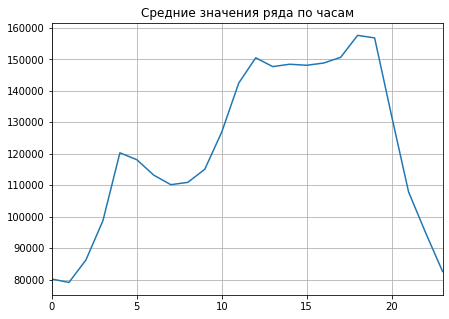

In [36]:
plt.figure(figsize=(7, 5))
plt.title("Средние значения ряда по часам")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

А теперь, объединим все преобразования под одной функцией и добавим к признакам кодирование средним

In [37]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # Создадим копию исходного датафрейма, чтобы можно было выполнять различные преобразования
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # Добавляем лаги целевой переменной
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # Добавляем данные по часу, дню недели и выходным
    data.index = data.index.to_pydatetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # считаем средние только по тренировочной части, чтобы избежать лика
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # выкидываем закодированные средними признаки 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # Делим на тренировочную и тестовую
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

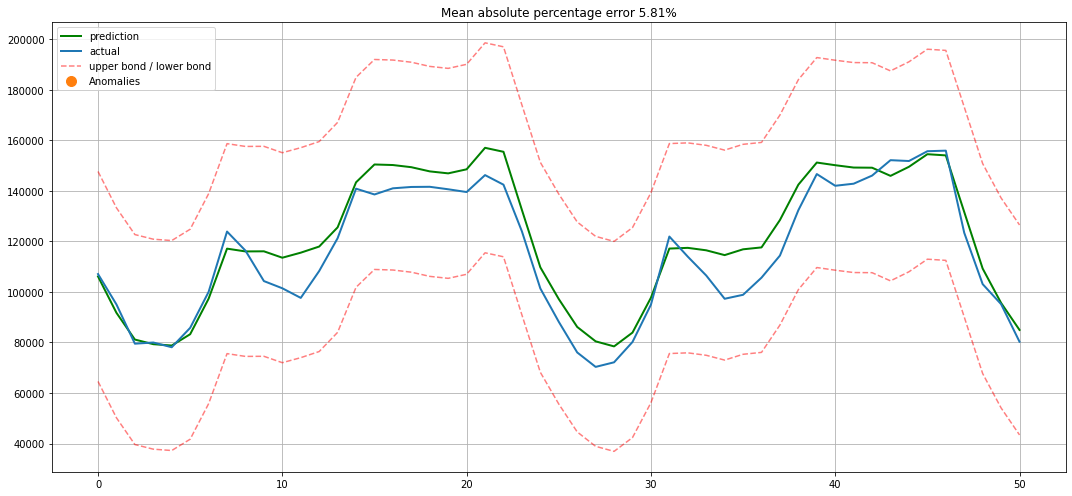

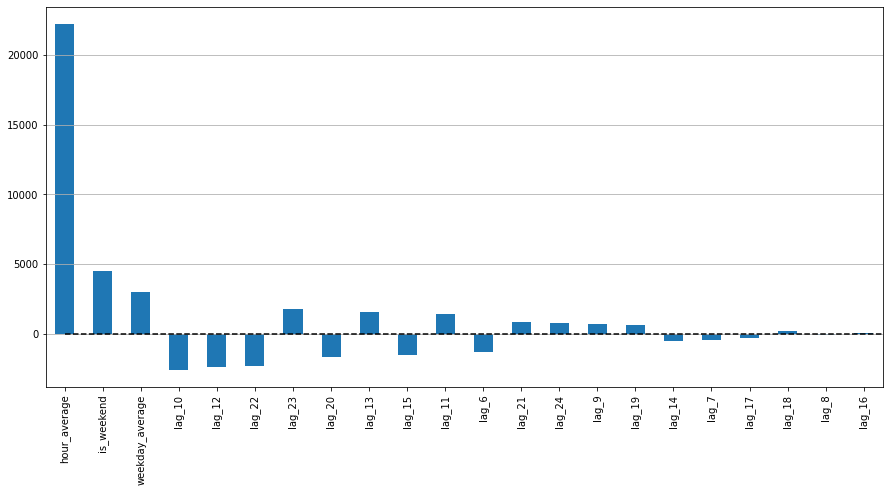

In [38]:
X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

А вот и немного переобучения, переменная hour_average настолько понравилась нашей модели на тренировочном датасете, что по ней, в основном, модель и стала прогнозировать. Решить эту проблему можно по-разному, например, считать средние таргета не по всему тренировочному датасету, а по некоторому последнему окну, которое будет лучше отражать последующее состояние ряда. Можно и просто руками выкинуть эту переменную, раз мы уверены, что она ведёт к ухудшению качества, что мы сейчас и сделаем.

In [39]:
X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Регуляризация и отбор признаков

Как мы уже выяснили, не все признаки одинаково полезны, а некоторые даже вредны и от них нужно срочно избавляться. Помимо выкидывания руками некоторых признаков, можно заняться регуляризацией. Сейчас мы рассмотрим две наиболее распространенных модели с регуляризацией - ридж и лассо регрессии. Они добавляют к нашей функции потерь, при помощи которой мы оптимизируем значения коэффициентов модели, еще немножко ограничений. 

В случае с ридж регрессией - это сумма квадратов коэффициентов модели, помноженная на коэффициент регуляризации. Т.е. чем больше значение коэффициента у переменной, тем больше будет наша ошибка, а значит, мы будем стараться оптимизировать одновременно как подгонку модели под данные, так и не давать коэффициентам сильно разрастаться. 

В результате такой регуляризации, которая носит гордое название $L2$, мы получаем бОльшее смещение, но меньший разброс, т.е. модель будет (по крайней мере мы на это очень надеемся) обладать лучшей обобщающей способностью. 

Вторая модель - лассо регрессия, в ней к функционалу ошибки добавляются не квадраты, а модули коэффициентов, в результате чего во время оптимизации коэффициенты перед факторами, которые оказываются не так важны, просто зануляются. Такой тип регуляризации называется $L1$. Таким образом, лассо регрессия автоматически позволяет производить отбор факторов для модели, сокращая признаковое пространство.

Для начала убедимся, что нам есть, что отбрасывать и в данных действительно очень много скоррелированных признаков

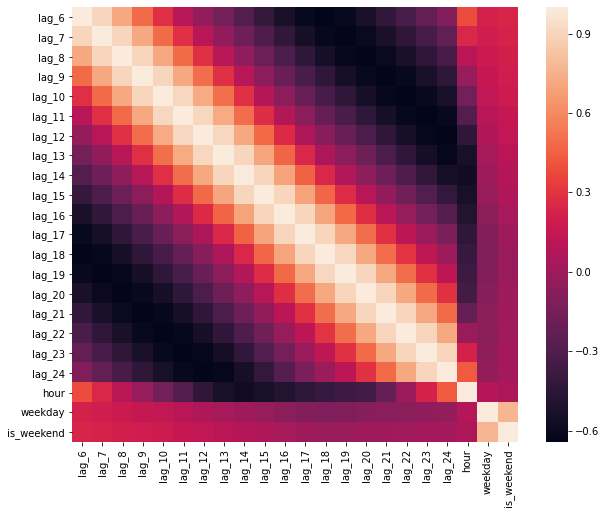

In [40]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

In [41]:
from sklearn.linear_model import LassoCV, RidgeCV

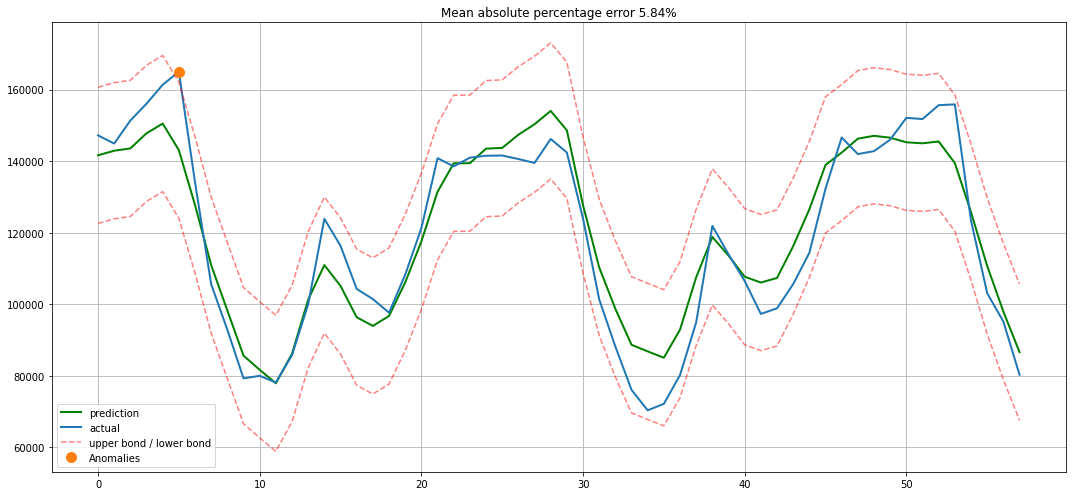

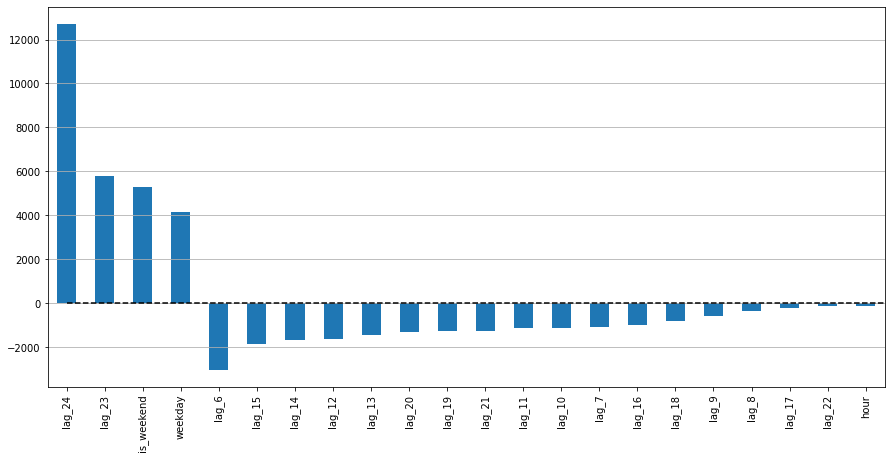

In [42]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

Хорошо видно, как всё ближе и ближе прижимаются к нулю (хотя никогда нулю не равны) коэффициенты в модели по мере убывания их важности. 

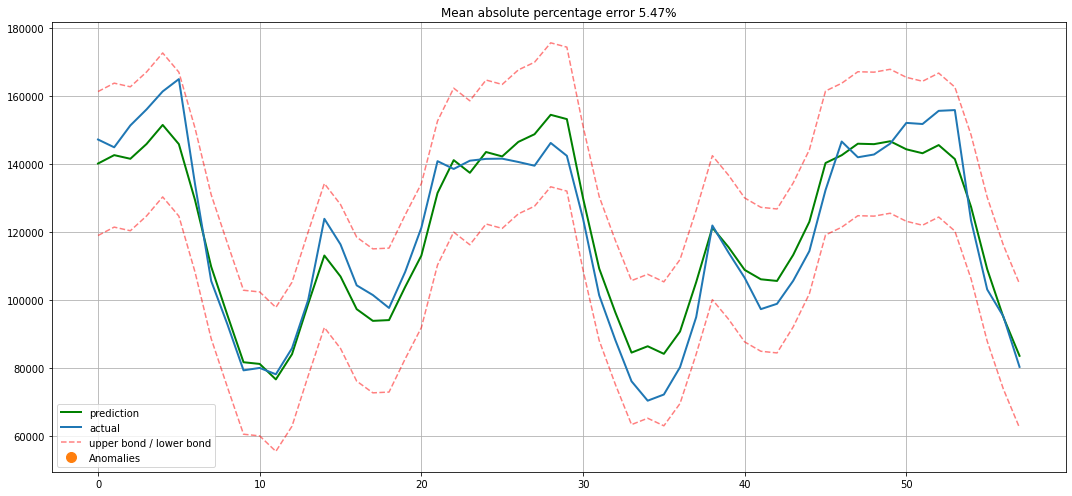

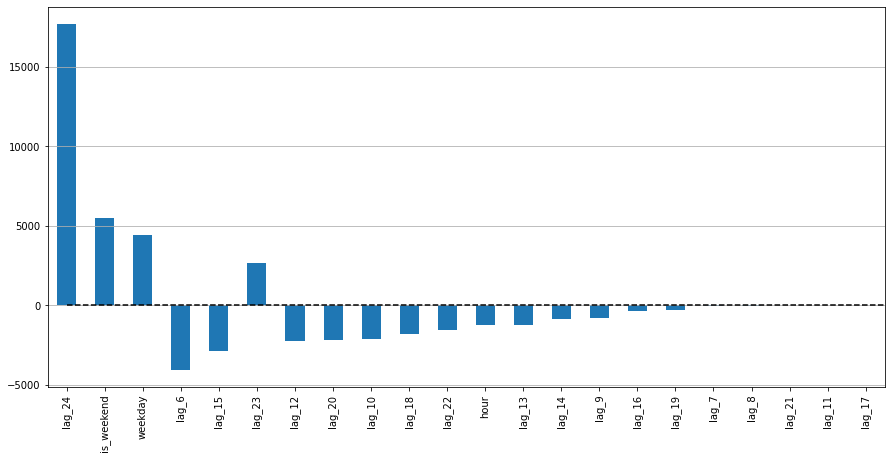

In [43]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

Лассо регрессия оказалась более консервативой и убрала 23-й лаг из важных факторов модели, что, в результате, только пошло на пользу качеству на отложенной выборке.

## Boosting



In [44]:
!pip install xgboost

In [45]:
import sys

from xgboost import XGBRegressor 

In [46]:
xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

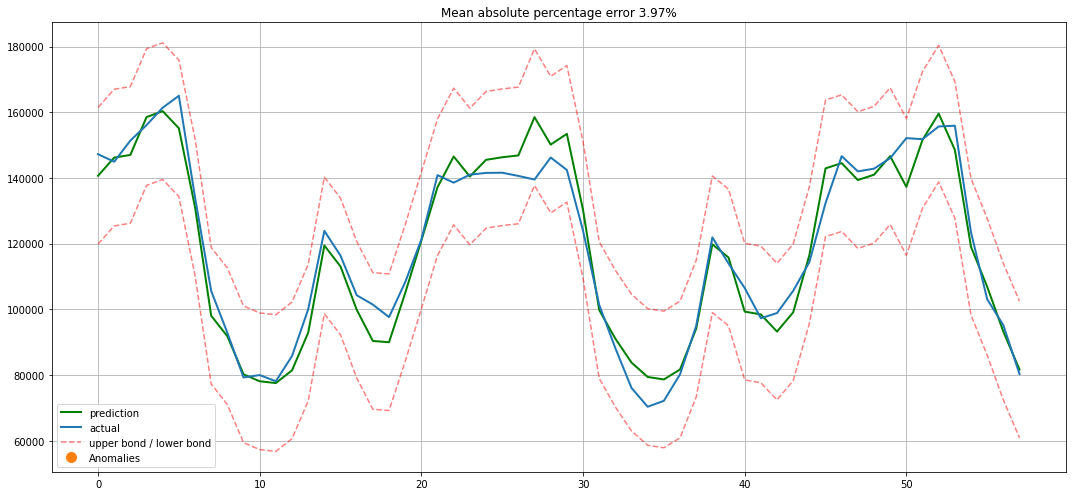

In [47]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

Маленькая ошибка на отложенной выборке из всех опробованных.

Однако эта победа обманчива и не стоит первым делом при работе с временным рядом расчехлять xgboost. Дело в том, что модели с деревьями внутри, в отличие от линейных, довольно плохо справляются с трендами без помощи трюков с обработкой данных. В идеале - предварительно очистить данные от тренда, спрогнозировать тренд отдельно при помощи линейной модели, и отдельно - очищенный ряд, а потом сложить вместе предсказания. 

Снова небольшим домашним заданием будет построение моделей для второго временного ряда, с внутриигровой валютой.

Задание 1.

- Изменить функцию `prepareData` так, чтобы она не извлекала признак "час" и "среднее по часу", а вместо этого добавить извлечение признака "день месяца" и "среднее по дню месяца"
- Подготовить данные для построения модели, взяв `lag_start = 7`, чтобы модель могла прогнозировать на неделю вперед, а `lag_end = 31`, чтобы месячная сезонность также попала в наблюдаемые моделью значения
- Построить линейную модель с `target_encoding` (среднее по дню месяца) и без, проверить, что лучше
- Построить ридж и лассо регрессии, посмотреть, какие факторы модели считают наиболее важными
- Забустить этот временной ряд и убедиться, что по умолчанию `xgb` будет давать отвратительный результат
Задание 2. 
- Разбейте подготовленные данные на `train` и `test`
- Очистите временной ряд от линейного тренда при помощи построения однофакторной линейной регрессии, где таргетом будут значения ряда, а фактором - числовой ряд от 0 до `len(train)`. Предсказанные по такой модели значения будут линейным трендом, который нужно вычесть из исходного ряда (подбробнее можно посмотреть [здесь](https://machinelearningmastery.com/time-series-trends-in-python/))
- Теперь спрогнозируйте значения тренда по этой модели для тестового датасета, для этого нужно в качестве фактора взять числовой ряд от `len(train)` до `len(test)`, очистите тестовый датасет от тренда при помощи этого прогноза
- Далее на очищенных от тренда данных `train` постройте xgboost и постройте прогноз на `test`
- Наконец, просуммируйте предсказанное значение тренда и прогнозы бустинга, чтобы получить красивый итоговый прогноз временного ряда

## Facebook Prophet - автоматические прогнозы

https://facebook.github.io/prophet/


https://github.com/facebook/prophet

Библиотека для прогнозирования временных рядов Facebook Prophet. Предназначена для прогнозирования большого числа различных бизнес-показателей.


пример прогнозирования постов
(https://habrahabr.ru/company/ods/blog/323730/)


В основе аддитивная регрессионная модель(непараметрический метод, более гибкий , чем стандартная линейная модель)

$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}$

Состоит из следующих компонент:

1) Сезонные компоненты  s(t) отвечают за моделирование периодических изменений, связанных с недельной и годовой сезонностью. Недельная сезонность моделируется с помощью dummy variables. Добавляются 6 дополнительных признаков, например, [monday, tuesday, wednesday, thursday, friday, saturday], которые принимают значения 0 и 1 в зависимости от даты. Признак sunday, соответствующий седьмому дню недели, не добавляют, потому что он будут линейно зависеть от других дней недели и это будет влиять на модель.

2) Тренд  g(t) — это кусочно-линейная или логистическая функция. Логистическая же функция вида $ g(t) = \frac{C}{1+exp(-k(t-b))}$ позволяет моделировать рост с насыщением, когда при увеличении показателя снижается темп его роста. 

Пример — это рост аудитории приложения или сайта.

3) Компонента $h(t)$ отвечает за заданные пользователем аномальные дни, в том числе и нерегулярные, такие как, например, Black Fridays.

4) Ошибка $\epsilon_{t}$ содержит информацию, которая не учтена моделью.


In [1]:
conda install -c conda-forge fbprophet

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Alsu1\Anaconda3

  added / updated specs:
    - fbprophet


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    arviz-0.7.0                |             py_0         1.3 MB  conda-forge
    certifi-2019.11.28         |   py37hc8dfbb8_1         149 KB  conda-forge
    cftime-1.1.1               |   py37hbc2f12b_0         225 KB  conda-forge
    conda-4.8.3                |   py37hc8dfbb8_1         3.1 MB  conda-forge
    convertdate-2.1.3          |          py_1000          30 KB  conda-forge
    ephem-3.7.7.1              |   py37hfa6e2cd_0         741 KB  conda-forge
    fbprophet-0.6              |   py37h6538335_0         521 KB  conda-forge
    holidays-0.10.1            |             py_0          56 KB  conda-forge
    libpython-2.0              |           py37_0          47 KB  conda-forge


In [2]:
conda install -c conda-forge/label/cf201901 fbprophet

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Alsu1\Anaconda3

  added / updated specs:
    - fbprophet


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2018.11.29 |       ha4d7672_0         179 KB  conda-forge/label/cf201901
    certifi-2018.11.29         |        py37_1000         144 KB  conda-forge/label/cf201901
    openssl-1.1.1e             |       he774522_0         4.8 MB
    ------------------------------------------------------------
                                           Total:         5.1 MB

The following packages will be UPDATED:

  openssl            conda-forge::openssl-1.1.1d-hfa6e2cd_0 --> pkgs/main::openssl-1.1.1e-he774522_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2019.11.~ --> conda-forge/label/cf201901::ca-certifica

In [48]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [62]:
# задаем число предсказаний будущих значений
predictions = 60

# создаем специфический датасет, с определенными названиями столбцов
df = ads.reset_index()
df.columns = ['ds', 'y']
df.tail()


,ds,y
211,2017-09-21 19:00:00,155890
212,2017-09-21 20:00:00,123395
213,2017-09-21 21:00:00,103080
214,2017-09-21 22:00:00,95155
215,2017-09-21 23:00:00,80285


Для того чтобы измерить качество полученного прогноза, уберем из обучения два последних месяца данных и будем предсказывать его. Советуют делать предсказания по нескольким месяцам данных, в идеале – год и более.

In [61]:

# откладываем часть данных для тестирования
train_df = df[:-predictions]

Библиотека Prophet имеет интерфейс похожий на sklearn, сначала мы создаем модель, затем вызываем у нее метод fit и затем получаем прогноз. На вход методу fit библиотека принимает dataframe с двумя колонками:


ds — время, поле должно быть типа date или datetime,
y — числовой показатель, который мы хотим предсказывать.

Создаем объект класса Prophet и обучаем его.


In [64]:
# обучаем модель, обязательно указывая тип сезонности, который хотим использовать

model = Prophet(weekly_seasonality=True)
model.fit(train_df)



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds
211,2017-09-21 19:00:00
212,2017-09-21 20:00:00
213,2017-09-21 21:00:00
214,2017-09-21 22:00:00
215,2017-09-21 23:00:00


С помощью вспомогательной функции Prophet.make_future_dataframe создаем dataframe, который содержит все исторические временные точки и еще 60 дней, для которых мы хотели построить прогноз.

In [ ]:
# создаем специфический датафрейм, который нужен для предсказаний
# здесь нужно указать частоту данных (по умолчанию - дни)
future = model.make_future_dataframe(periods=predictions, freq='H')
future.tail()



Для того, чтобы построить прогноз вызываем у модели функцию predict и передаем в нее полученный на предыдущем шаге dataframe future.

In [66]:
# делаем предсказания 
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
211,2017-09-21 19:00:00,126971.027255,140110.742732,161748.140026,126970.739060,126971.304893,24042.202443,24042.202443,24042.202443,27772.557347,27772.557347,27772.557347,-3730.354905,-3730.354905,-3730.354905,0.0,0.0,0.0,151013.229698
212,2017-09-21 20:00:00,126997.968784,123772.136240,145805.742290,126997.673406,126998.255615,7747.569443,7747.569443,7747.569443,11521.169106,11521.169106,11521.169106,-3773.599663,-3773.599663,-3773.599663,0.0,0.0,0.0,134745.538227
213,2017-09-21 21:00:00,127024.910313,103522.574322,124692.438110,127024.604480,127025.203407,-12948.825689,-12948.825689,-12948.825689,-9158.744412,-9158.744412,-9158.744412,-3790.081277,-3790.081277,-3790.081277,0.0,0.0,0.0,114076.084624
214,2017-09-21 22:00:00,127051.851842,85176.645667,106046.726501,127051.535348,127052.151035,-31607.793587,-31607.793587,-31607.793587,-27827.822589,-27827.822589,-27827.822589,-3779.970997,-3779.970997,-3779.970997,0.0,0.0,0.0,95444.058255
215,2017-09-21 23:00:00,127078.793371,73309.496689,93909.958009,127078.468601,127079.102671,-43864.425752,-43864.425752,-43864.425752,-40120.806710,-40120.806710,-40120.806710,-3743.619042,-3743.619042,-3743.619042,0.0,0.0,0.0,83214.367619


В библиотеке Prophet есть встроенные средства визуализации, которые позволяют оценить результат построенной модели.


Во-первых, метод Prophet.plot отображает прогноз. 

Mean absolute percentage error 8.59%


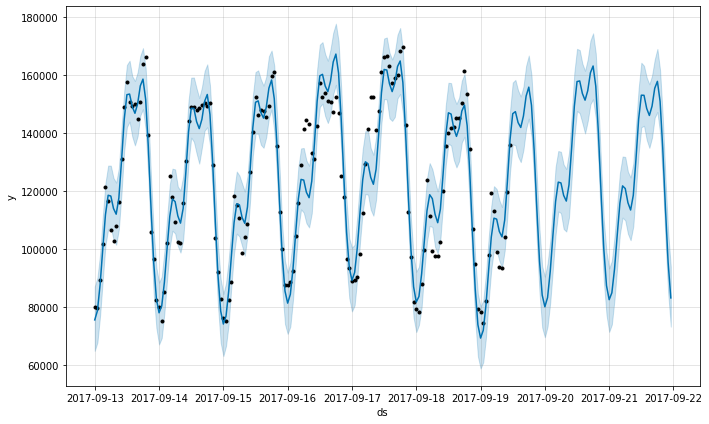

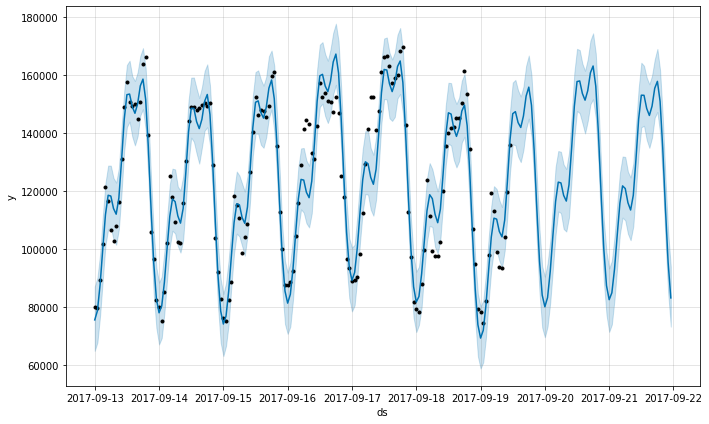

In [68]:
error = mean_absolute_percentage_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
model.plot(forecast)

Также можно посмотреть на декомпозицию исходного ряда на составляющие.
Вторая функция Prophet.plot_components позволяет посмотреть отдельно на компоненты: тренд, годовую и недельную сезонность. Если при построении модели были заданы аномальные дни/праздники, то они также будут отображаться на этом графике.

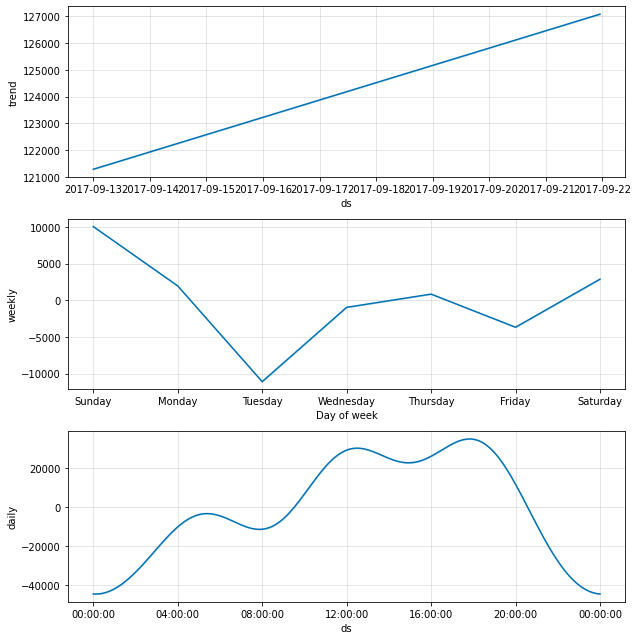

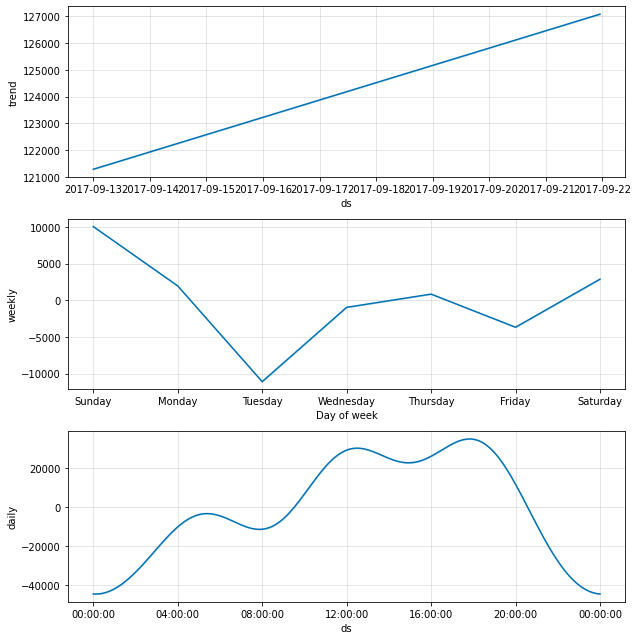

In [67]:
model.plot_components(forecast)

 По недельной сезонности можно сделать вывод, что меньше просмотров приходится на вторник. На дневной сезонности ярче всего выделяется провал активности в полночь.